In [2]:
import pickle

import category_encoders as ce
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

# import xgboost as xgb
# import lightgbm as lgb

In [3]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized_BE.parquet.gzip"
)

test_data = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_featurized_BE.parquet.gzip')

test_data_old = pd.read_parquet('../data/processed/chrome/08_12_2022/test_set_01_featurized_BE.parquet.gzip')

In [41]:
len(train_data) / (2 * np.bincount(train_data['tracker']))

array([0.69857462, 1.75897257])

In [4]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

In [5]:
X_test_old, y_test_old = test_data_old.iloc[:, :-1], test_data_old[["tracker"]]

del test_data_old

Model accuracy score : 0.9238
Balanced accuracy score : 0.9035
F1 score : 0.8535
Model log-loss score : 0.4956
Matthews correlation coefficient score : 0.8021
Precision score : 0.8456
Recall score : 0.8616
Model auc score : 0.9035
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    596066
           1       0.85      0.86      0.85    206747

    accuracy                           0.92    802813
   macro avg       0.90      0.90      0.90    802813
weighted avg       0.92      0.92      0.92    802813



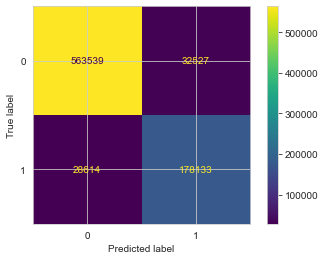

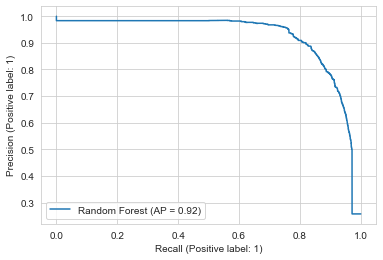

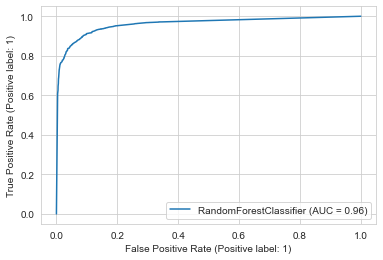

In [25]:
# clf.fit(X_train, y_train["tracker"])
# calculate_metrics(X_test, y_test)

\footnote{. \url{}, [Accessed Jan. 31, 2023]}

In [3]:
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

In [8]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10, criterion="gini",
                                            max_features=None),
    # "KNN": KNeighborsClassifier(n_jobs=-1),
    "Decision_Tree": DecisionTreeClassifier(random_state=10),
    # "Gradient Boosting": GradientBoostingClassifier(random_state=10),
    # "Hist Gradient Boosting": HistGradientBoostingClassifier(
    #         random_state=10
    #     ),
    # "XGBoost": XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss"),
    # "LightGBM": LGBMClassifier(random_state=10, class_weight="balanced"),
    "Logistic_Regression": LogisticRegression(random_state=10, max_iter=1000, solver='newton-cholesky'),
    # "Gaussian NB": GaussianNB()
}

In [9]:
from typing import Dict, List, Tuple

In [10]:
def calculate_metrics(
        y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import BaseCrossValidator


def calculate_metrics(
        y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and
    predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": np.round(metrics.accuracy_score(y_true, y_pred), 3),
        "log_loss": np.round(score, 3),
        "auc": np.round(auc_score, 3),
        "balanced_accuracy": np.round(bal_acc, 3),
        "f1": np.round(f1_score, 3),
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "mcc": np.round(mcc, 3),
    }


def calculate_confusion_matrix_elements(
        y_true: pd.Series, y_pred: np.ndarray
) -> Dict[str, int]:
    """
    Calculate the confusion matrix elements (FP, TN, FN, TP) for the given true
    and predicted values.

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : np.ndarray
        Predicted target values.

    Returns
    -------
    Dict[str, int]
        A dictionary containing the confusion matrix elements (FP, TN, FN, TP).
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    print(type(fn))
    return {"FP": int(fp), "TN": int(tn), "FN": int(fn), "TP": int(tp)}


def train_and_evaluate_models_2(
        models: Dict[str, BaseEstimator],
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        cv: BaseCrossValidator,
        clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor), ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.mean(cv_results["test_" + metric])
            for metric in scoring_metrics.keys()
        }

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]

        # filename = "random_forest_v3_binary.sav"
        # pickle.dump(clf['classifier'], open(f'../../../models/chrome/08_12_2022/{filename}', 'wb'))

        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

        test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
        test_metrics.update(calculate_confusion_matrix_elements(y_test, y_pred_test))

        mean_cv_metrics.update({"test_" + k: v for k, v in test_metrics.items()})
        all_mean_metrics[model_name] = mean_cv_metrics

    return pd.DataFrame(all_mean_metrics).T
    # return best_estimator


def train_models(
        models: Dict[str, BaseEstimator],
        X_train: pd.DataFrame,
        y_train: pd.Series,
        cv: BaseCrossValidator,
        clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor), ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.round(np.mean(cv_results["test_" + metric]), 3)
            for metric in scoring_metrics.keys()
        }
        all_mean_metrics[model_name] = mean_cv_metrics

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]

        filename = f"{model_name}_binary.sav"
        pickle.dump(
            best_estimator["classifier"],
            open(f"../models/chrome/08_12_2022/{filename}", "wb"),
        )

    return pd.DataFrame(all_mean_metrics).T

In [12]:
from joblib import Parallel, delayed

In [13]:
def calculate_single_bootstrap_sample(y_true, y_pred, y_pred_proba, random_state):
    sample_idx = random_state.choice(len(y_true), len(y_true), replace=True)
    y_true_sample = y_true.iloc[sample_idx]
    y_pred_sample = y_pred[sample_idx]
    y_pred_proba_sample = y_pred_proba[sample_idx]

    return calculate_metrics(y_true_sample, y_pred_sample, y_pred_proba_sample)


def calculate_confidence_intervals(
        y_true: pd.Series,
        y_pred: np.ndarray,
        y_pred_proba: np.ndarray,
        n_bootstrap_samples: int = 10,
        random_state: int = 10,
        n_jobs: int = -1,
) -> Dict[str, Tuple[float, float]]:
    rng = np.random.RandomState(random_state)
    random_states = [
        np.random.RandomState(rng.randint(np.iinfo(np.int32).max))
        for _ in range(n_bootstrap_samples)
    ]

    bootstrap_metrics = Parallel(n_jobs=n_jobs)(
        delayed(calculate_single_bootstrap_sample)(y_true, y_pred, y_pred_proba, rs)
        for rs in random_states
    )

    confidence_intervals = {}
    for metric in bootstrap_metrics[0].keys():
        sorted_bootstrap_values = sorted(
            [sample_metrics[metric] for sample_metrics in bootstrap_metrics]
        )
        ci_lower = np.round(np.percentile(sorted_bootstrap_values, 2.5), 3)
        ci_upper = np.round(np.percentile(sorted_bootstrap_values, 97.5), 3)
        confidence_intervals[metric + "_CI"] = (ci_lower, ci_upper)

    return confidence_intervals

In [22]:
import gzip

In [25]:
def test_models(
        models: List[str],
        X_test: pd.DataFrame,
        y_test: pd.Series,
) -> List[pd.DataFrame]:
    all_mean_metrics = {}
    ci_results = {}

    for model_name in models:
        print(f"Evaluating {model_name}...")

        filename = f"{model_name}_BE.sav.gz"
        gzip_path = f"../models/chrome/08_12_2022/{filename}"

        with gzip.GzipFile(gzip_path, "rb") as f:
            best_estimator = pickle.load(f)

        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

        # confidence_intervals = calculate_confidence_intervals(
        #     y_test, y_pred_test, y_pred_proba_test
        # )

        # ci_results[model_name] = confidence_intervals

        test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
        test_metrics.update(calculate_confusion_matrix_elements(y_test, y_pred_test))

        final_metrics = {}
        final_metrics.update({"test_" + k: v for k, v in test_metrics.items()})
        all_mean_metrics[model_name] = final_metrics

    data = {model_name: {} for model_name in models}
    # for model_name, ci in ci_results.items():
    #     for metric, bounds in ci.items():
    #         lower_key = f"{metric}_lower"
    #         upper_key = f"{metric}_upper"
    #         data[model_name][lower_key] = bounds[0]
    #         data[model_name][upper_key] = bounds[1]

    ci_df = pd.DataFrame.from_dict(data, orient='index')

    return [pd.DataFrame(all_mean_metrics).T, ci_df]

In [39]:
# from sklearn.model_selection import (
#     StratifiedShuffleSplit,
# )

In [15]:
# split = StratifiedShuffleSplit(n_splits=1, random_state=10, test_size=0.2)
split2 = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

In [58]:
split3 = RepeatedStratifiedKFold(random_state=10, n_splits=5, n_repeats=5)

In [ ]:
# %%time
# train_and_evaluate_models(models, X_train, y_train['tracker'], split2)

In [98]:
%%time
train_models(models, X_train, y_train['tracker'], split2)

Training and evaluating Decision_Tree...
Training and evaluating Logistic_Regression...


KeyboardInterrupt: 

In [29]:
models = [
            "Logistic_Regression",
            "Gaussian_NB",
            "Bernoulli_NB",
            "Decision_Tree",
            "Random_Forest",
            "Extra_Trees_Classifier",
            "Ada_Boost",
            "Gradient_Boosting",
            "LightGBM",
            "Hist_GB",
            "XGBoost",
        ]

In [ ]:
X_test_train_2, y_test_train_2

In [79]:
%%time
a = test_models(models, X_test_train_2, y_test_train_2)

Evaluating Logistic_Regression...
Evaluating Gaussian_NB...
Evaluating Bernoulli_NB...
Evaluating Decision_Tree...
Evaluating Random_Forest...
Evaluating Extra_Trees_Classifier...
Evaluating Ada_Boost...
Evaluating Gradient_Boosting...
Evaluating LightGBM...
Evaluating Hist_GB...
Evaluating XGBoost...
CPU times: user 8.82 s, sys: 5.58 s, total: 14.4 s
Wall time: 3.6 s


In [80]:
a[0]

,test_accuracy,test_log_loss,test_auc,test_aupcr,test_balanced_accuracy,test_f1,test_fbeta,test_precision,test_recall,test_mcc,test_jaccard,test_FP,test_TN,test_FN,test_TP
Logistic_Regression,0.897,0.241,0.861,0.902,0.861,0.811,0.833,0.847,0.778,0.742,0.683,2166.0,36770.0,3427.0,12037.0
Gaussian_NB,0.868,2.519,0.816,0.780,0.816,0.750,0.786,0.812,0.697,0.665,0.600,2491.0,36445.0,4692.0,10772.0
Bernoulli_NB,0.856,0.596,0.834,0.845,0.834,0.756,0.741,0.731,0.783,0.655,0.608,4461.0,34475.0,3356.0,12108.0
Decision_Tree,0.963,0.364,0.951,0.962,0.951,0.934,0.942,0.948,0.921,0.909,0.877,786.0,38150.0,1216.0,14248.0
Random_Forest,0.964,0.128,0.953,0.983,0.953,0.937,0.944,0.949,0.925,0.912,0.881,774.0,38162.0,1159.0,14305.0
Extra_Trees_Classifier,0.964,0.176,0.951,0.979,0.951,0.936,0.946,0.953,0.920,0.912,0.880,695.0,38241.0,1243.0,14221.0
Ada_Boost,0.893,0.568,0.859,0.894,0.859,0.805,0.822,0.834,0.779,0.733,0.674,2407.0,36529.0,3413.0,12051.0
Gradient_Boosting,0.903,0.235,0.874,0.912,0.874,0.825,0.838,0.846,0.805,0.759,0.703,2261.0,36675.0,3008.0,12456.0
LightGBM,0.936,0.163,0.913,0.958,0.913,0.885,0.900,0.910,0.861,0.841,0.793,1319.0,37617.0,2153.0,13311.0
Hist_GB,0.934,0.164,0.911,0.958,0.911,0.881,0.896,0.906,0.857,0.836,0.788,1370.0,37566.0,2205.0,13259.0


In [ ]:
# RAYFRIENDS10

In [112]:
a[0]

,test_accuracy,test_log_loss,test_auc,test_balanced_accuracy,test_f1,test_precision,test_recall,test_mcc,test_FP,test_TN,test_FN,test_TP
Logistic_Regression,0.892,0.252,0.855,0.855,0.787,0.796,0.779,0.715,41224.0,554842.0,45725.0,161022.0
Decision_Tree,0.917,1.853,0.896,0.896,0.840,0.828,0.852,0.784,36481.0,559585.0,30535.0,176212.0


In [116]:
a[1]

,accuracy_CI_lower,accuracy_CI_upper,log_loss_CI_lower,log_loss_CI_upper,auc_CI_lower,auc_CI_upper,balanced_accuracy_CI_lower,balanced_accuracy_CI_upper,f1_CI_lower,f1_CI_upper,precision_CI_lower,precision_CI_upper,recall_CI_lower,recall_CI_upper,mcc_CI_lower,mcc_CI_upper
Logistic_Regression,0.891,0.892,0.251,0.253,0.854,0.856,0.854,0.856,0.786,0.789,0.794,0.797,0.777,0.781,0.713,0.717
Decision_Tree,0.916,0.917,1.841,1.869,0.895,0.896,0.895,0.896,0.840,0.841,0.827,0.829,0.851,0.854,0.783,0.785


In [80]:
%%time
test_models(['Logistic Regression'], X_test, y_test['tracker'])

Evaluating Logistic Regression...
   accuracy_CI  log_loss_CI  auc_CI  balanced_accuracy_CI  f1_CI   
0        0.891        0.251   0.854                 0.854  0.786  \
1        0.892        0.253   0.856                 0.856  0.789   

   precision_CI  recall_CI  mcc_CI  
0         0.795      0.777   0.713  
1         0.798      0.780   0.716  
<class 'numpy.int64'>
CPU times: user 3.7 s, sys: 2.67 s, total: 6.37 s
Wall time: 1min 19s


,test_FN,test_FP,test_TN,test_TP,test_accuracy,test_auc,test_balanced_accuracy,test_f1,test_log_loss,test_mcc,test_precision,test_recall
Logistic Regression,45725.0,41224.0,554842.0,161022.0,0.892,0.855,0.855,0.787,0.252,0.715,0.796,0.779


In [38]:
filename = "Decision_Tree_binary.sav"
with open(f"../models/chrome/08_12_2022/{filename}", "rb") as f:
    best_estimator = pickle.load(f)

In [40]:
best_estimator.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [11]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split3)

NameError: name 'split3' is not defined

In [22]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split2)

Training and evaluating Random Forest...
CPU times: user 15.2 s, sys: 1.48 s, total: 16.6 s
Wall time: 1min 3s


,accuracy,balanced_accuracy,f1,mcc,neg_log_loss,precision,recall,roc_auc,test_FN,test_FP,test_TN,test_TP,test_accuracy,test_auc,test_balanced_accuracy,test_f1,test_log_loss,test_mcc,test_precision,test_recall
Random Forest,0.964989,0.953056,0.937606,0.913435,-0.130888,0.95014,0.9254,0.992407,29064.0,31252.0,564814.0,177683.0,0.924869,0.903496,0.903496,0.854899,0.491768,0.804233,0.850422,0.859422


In [20]:
y_pred_test = model['classifier'].predict(X_test)
y_pred_proba_test = model['classifier'].predict_proba(X_test)[:, 1]
test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
print(test_metrics)

{'accuracy': 0.9248691787502196, 'log_loss': 0.4917676276513927, 'auc': 0.9034959751293761, 'balanced_accuracy': 0.9034959751293761, 'f1': 0.8548986965998047, 'precision': 0.8504223801660804, 'recall': 0.8594223858145463, 'mcc': 0.8042327760644166}


# ANCIENT CODE

In [118]:
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')

In [119]:
firefox

,hostname,pathname,filetype,filename,date,content-type,content-length,cache-control,content-disposition,etag,...,x-via-ssl,request-time,access-control-request-method,fss-proxy,x-dc,x-llid,x-b3-sampled,tracker,comb_col_non_tracker,comb_col_tracker
0,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,15780,"public, max-age=7200","inline; filename=""a3a95d10e1d03fe77d6b.webp""","""a76e19b58c5103936ca99a64e6c1d71d""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
1,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,1539,"public, max-age=7200",NaN,"w/""573591b2d822f76e9fa661dcdc83c284""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,"fri, 12 aug 2022 22:10:52 gmt",image/webp,9952,"public, max-age=7200","inline; filename=""29eab20501ed73f16eba.webp""","""97fe776c2cbd2cbaa24192f89eaefc74""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
3,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,41109,"public, max-age=7200","inline; filename=""22ab1ea08fc1962409f1.webp""","""6193272dc9caf2486c404218e1380542""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
4,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,<NA>,"public, max-age=14400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498363,nt.global.ssl.fastly.net,/images/1431839055959-1428713.jpg,jpg,1431839055959-1428713.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,230,NaN,inline;filename=1428713.jpg;filename*=utf-8''1...,"""lp0kw1rx62w0lmnah1yusy/dyxtczm9x1svbssqydcu""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
498364,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498365,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498366,nt.global.ssl.fastly.net,/images/1431846945741-petworthbeautiesbeautyro...,jpg,1431846945741-petworthbeautiesbeautyroom.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,206,NaN,inline;filename=petworthbeauties_beautyroom.jp...,"""a+x3kgq0g9qfmdlswkdp6yvat8wg4xh1vd6lv4reg+o""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0


In [121]:
X_test

,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,x-robots-tag_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564659,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564660,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564661,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)
# X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]

In [ ]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)
# X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [2]:
from typing import Dict, List
from sklearn.model_selection import StratifiedKFold

In [35]:
def calculate_metrics(y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }


def perform_cross_validation(X: pd.DataFrame, y: pd.Series, clf: Pipeline, cv: StratifiedKFold) -> List[
    Dict[str, float]]:
    """
    Perform cross-validation for a given classifier and dataset.

    Parameters
    ----------
    X : pd.DataFrame
        The feature matrix.
    y : pd.Series
        The target vector.
    clf : Pipeline
        The classifier pipeline.
    cv : StratifiedKFold
        The cross-validator providing train/test indices for each fold.

    Returns
    -------
    list
        A list of dictionaries containing classification metrics for each fold.
    """
    all_metrics = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
        all_metrics.append(fold_metrics)

    return all_metrics


def mean_metrics(all_metrics: List[Dict[str, float]]) -> Dict[str, float]:
    """
    Compute the mean values of classification metrics across folds.

    Parameters
    ----------
    all_metrics : list
        A list of dictionaries containing classification metrics for each fold.

    Returns
    -------
    dict
        A dictionary containing the mean values of classification metrics.
    """
    return {
        metric: np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
        for metric in all_metrics[0].keys()
    }

In [8]:
X, y = train_data.iloc[:, :-1], train_data["tracker"]

In [9]:
model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="gini",
    max_features=None,
)

In [10]:
numeric_transformer = Pipeline(
    steps=[("scaler", FunctionTransformer(np.log1p))]
)
norm_transformer = Pipeline(steps=[("norm_scaler", Normalizer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
        ("num", numeric_transformer, ["content-length"]),
        ("age", norm_transformer, ["age"]),
    ]
)

In [11]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [12]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [13]:
%%time
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

CPU times: user 5min 9s, sys: 2.81 s, total: 5min 12s
Wall time: 54.7 s


In [16]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)
X_test_data, y_test_data = test_data.iloc[:, :-1], test_data[["tracker"]]

In [18]:
all_metrics = perform_cross_validation(X, y, clf, cv)

In [14]:
mean_metrics = mean_metrics(all_metrics)

In [19]:
print("Mean metrics across the folds:")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")

Mean metrics across the folds:
accuracy: 0.9999
log_loss: 0.0016
auc: 0.9999
balanced_accuracy: 0.9999
f1: 0.9998
precision: 0.9999
recall: 0.9998
mcc: 0.9998


In [23]:
%%time
final_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)])  # Replace 'model' with your chosen model
final_model.fit(X, y)  # Assuming X_train and y_train are your training data

CPU times: user 34 s, sys: 251 ms, total: 34.3 s
Wall time: 6.23 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [30]:
y_test_pred = final_model.predict(X_test_data)
y_test_pred_proba = final_model.predict_proba(X_test_data)

In [32]:
calculate_metrics(y_test_data, y_test_pred, y_test_pred_proba)

{'accuracy': 0.9999264716695343,
 'log_loss': 0.0016761614843792978,
 'auc': 0.9999174477689411,
 'balanced_accuracy': 0.9999174477689411,
 'f1': 0.9998706707017408,
 'precision': 0.9998448088562413,
 'recall': 0.9998965338851526,
 'mcc': 0.9998193055376092}

In [42]:
def calculate_metrics_2(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test_data, y_pred))
    )
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_test_data, y_pred))

In [44]:
calculate_metrics_2(X_test_data, y_test_data)

Model accuracy score : 0.9999
Model log-loss score : 0.0017
Model auc score : 0.9999
Balanced accuracy score : 0.9999
F1 score : 0.9999
Precision score : 0.9998
Recall score : 0.9999
Matthews correlation coefficient score : 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48671
           1       1.00      1.00      1.00     19330

    accuracy                           1.00     68001
   macro avg       1.00      1.00      1.00     68001
weighted avg       1.00      1.00      1.00     68001



In [45]:
list(
    train_data.select_dtypes("category").columns.values.tolist()
)

['content-type',
 'accept-ranges',
 'etag',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'server',
 'alt-svc',
 'cross-origin-resource-policy',
 'access-control-allow-origin_cumulative']

In [34]:
import gzip

In [35]:
filename = f"LightGBM_BE.sav.gz"
filename1 = f"Random_Forest_BE.sav.gz"
filename2 = f"Logistic_Regression_BE.sav.gz"
filename3 = f"Hist_GB_BE.sav.gz"
filename4 = f"Ada_Boost_BE.sav.gz"
filename5 = f"Decision_Tree_BE.sav.gz"
filename6 = f"Extra_Trees_Classifier_BE.sav.gz"
filename7 = f"XGBoost_BE.sav.gz"
filename8 = f"Gradient_Boosting_BE.sav.gz"
filename9 = f"Gaussian_NB_BE.sav.gz"
filename10 = f"Bernoulli_NB_BE.sav.gz"

In [36]:
with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename}", "rb") as f:
    lgbm = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename1}", "rb") as f:
    rfc = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename2}", "rb") as f:
    lr = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename3}", "rb") as f:
    hgb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename4}", "rb") as f:
    ada = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename5}", "rb") as f:
    dt = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename6}", "rb") as f:
    et = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename7}", "rb") as f:
    xgb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename8}", "rb") as f:
    gb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename9}", "rb") as f:
    gnb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename10}", "rb") as f:
    nb = pickle.load(f)

In [37]:
clf_list = [
    (lr, "Logistic"),
    (hgb, "HGB"),
    (lgbm, "LGBM"),
    (rfc, "Random forest"),
    (ada, "Ada Boost"),
    (dt, "Decision tree"),
    (et, "Extra Trees Classifier"),
    (xgb, "XGBoost"),
    (gb, "Gradient boosting"),
    (gnb, "Gaussian NB"),
    (nb, "Naive Bayes"),
]

In [38]:
clf_list

[(LogisticRegression(max_iter=1000, n_jobs=-1, random_state=10,
                     solver='newton-cholesky'),
  'Logistic'),
 (HistGradientBoostingClassifier(random_state=10), 'HGB'),
 (LGBMClassifier(random_state=10), 'LGBM'),
 (RandomForestClassifier(max_features=None, n_jobs=-1, random_state=10),
  'Random forest'),
 (AdaBoostClassifier(random_state=10), 'Ada Boost'),
 (DecisionTreeClassifier(random_state=10), 'Decision tree'),
 (ExtraTreesClassifier(n_jobs=-1, random_state=10), 'Extra Trees Classifier'),
 (XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_bin=None, max_cat_threshold=None,
     

In [39]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_70210/2008148767.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

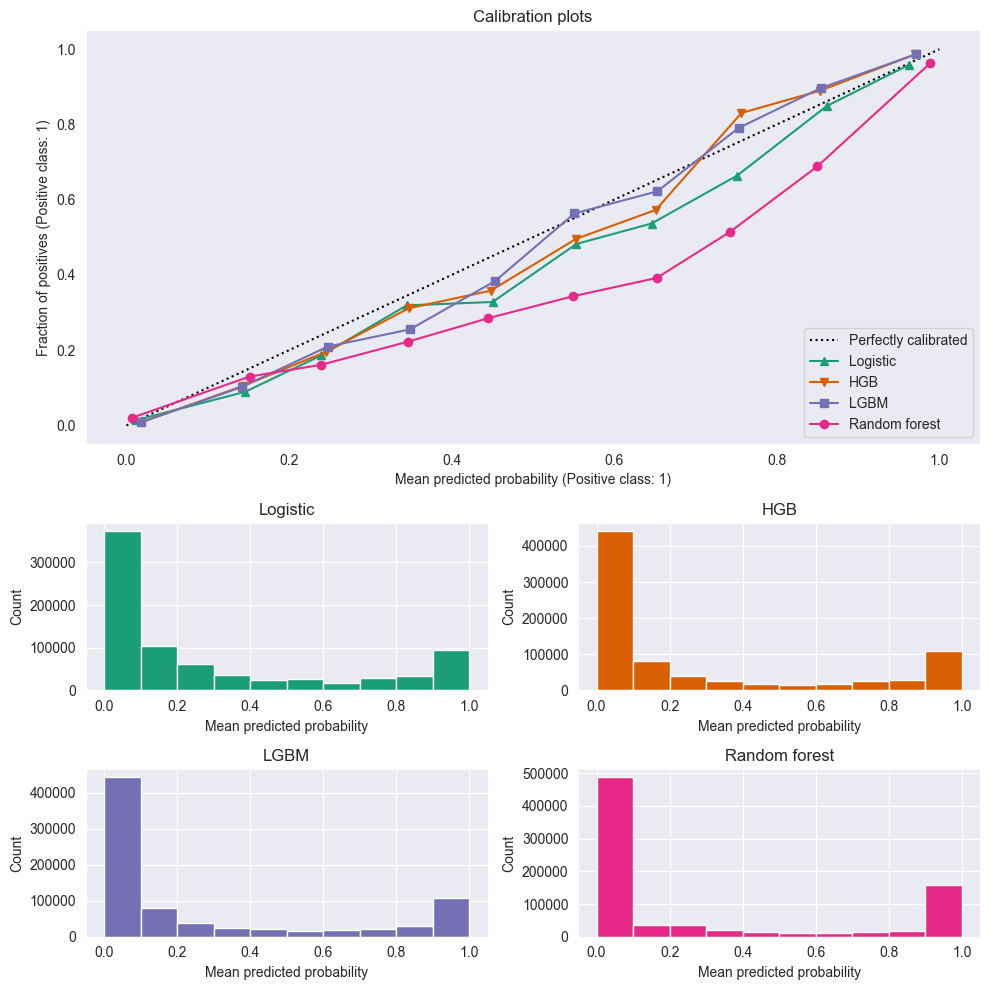

In [27]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_70210/2008148767.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

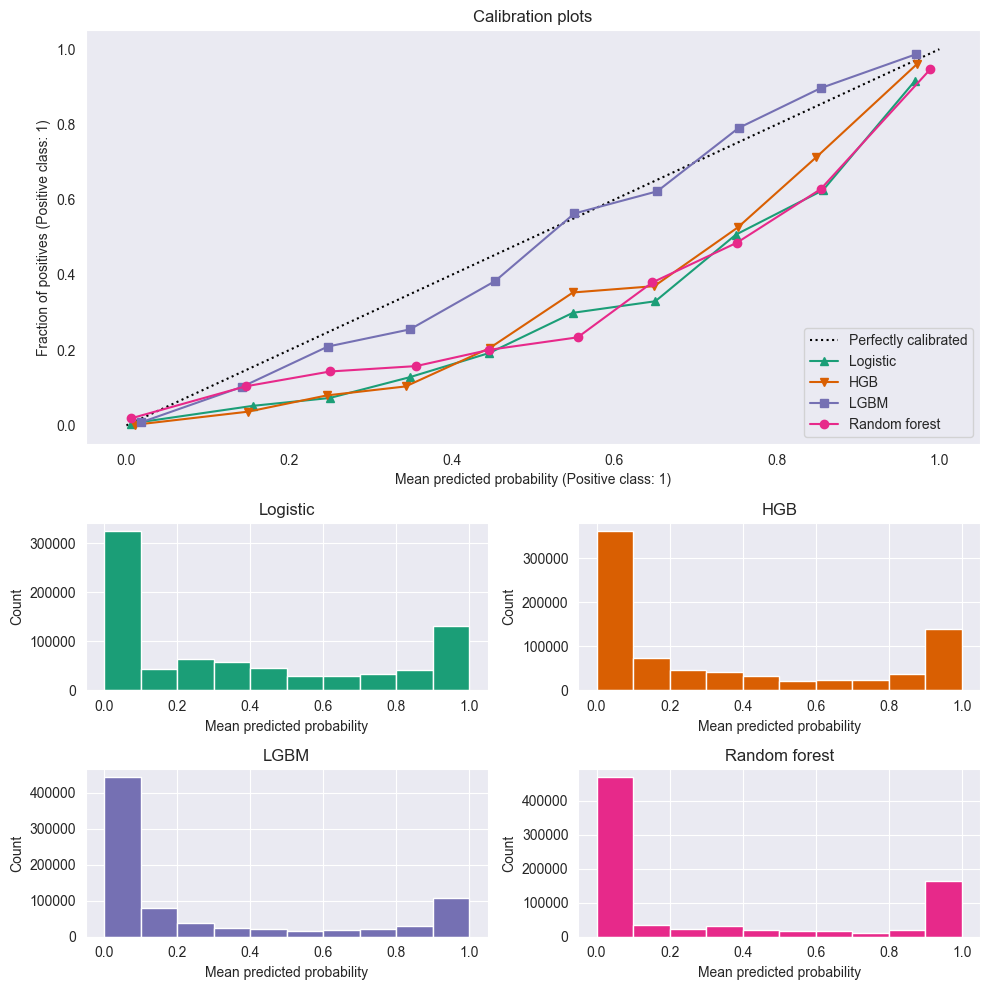

In [38]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_88743/1391889517.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

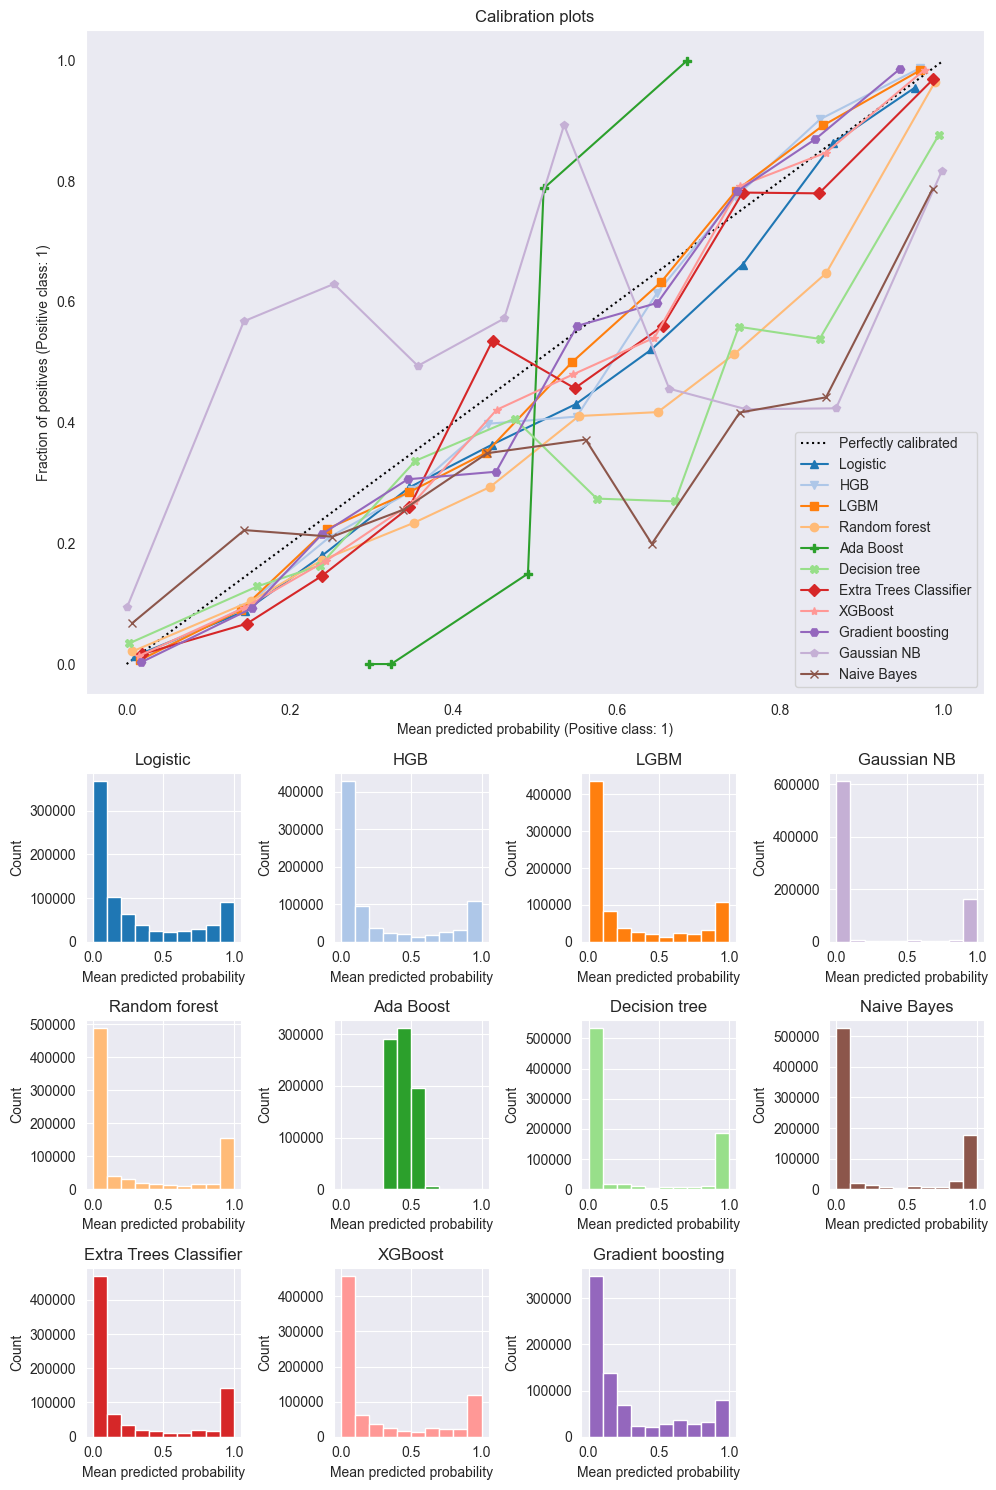

In [14]:
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(6, 6)
colors = plt.cm.get_cmap("tab20")

ax_calibration_curve = fig.add_subplot(gs[:3, :4])
calibration_displays = {}
markers = ["^", "v", "s", "o", "P", "X", "D", "*", "H", "p", "x"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [
    (3, 0), (3, 1), (3, 2),
    (4, 0), (4, 1), (4, 2),
    (5, 0), (5, 1), (5, 2),
    (3, 3), (4, 3)
]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_17805/2245985404.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

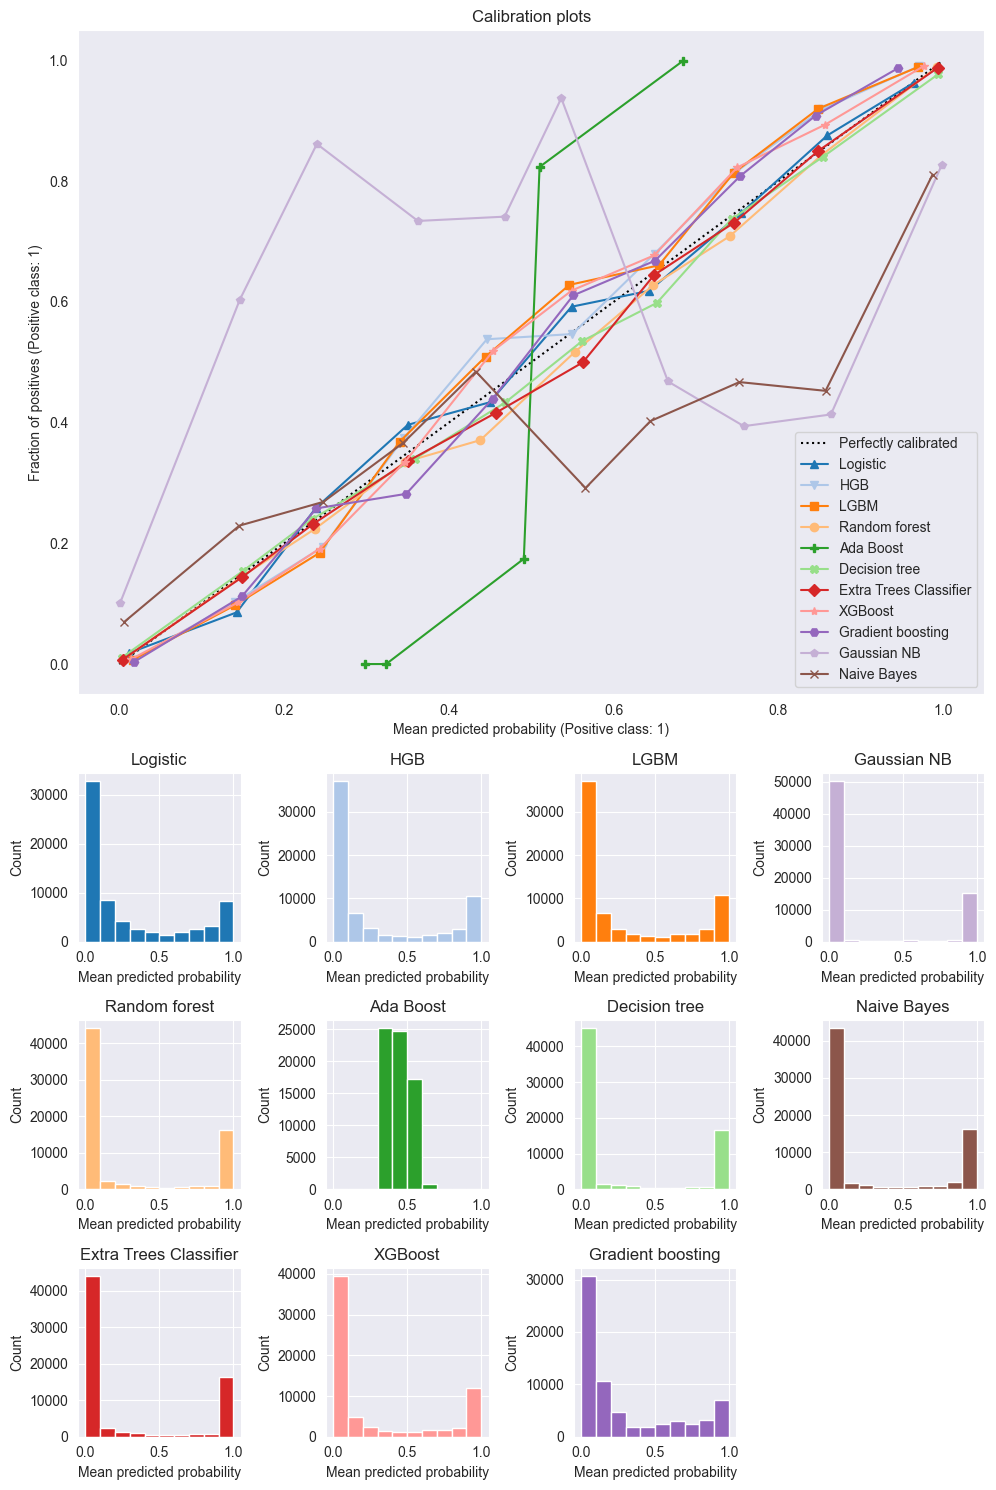

In [42]:
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(6, 6)
colors = plt.cm.get_cmap("tab20")

ax_calibration_curve = fig.add_subplot(gs[:3, :4])
calibration_displays = {}
markers = ["^", "v", "s", "o", "P", "X", "D", "*", "H", "p", "x"]
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_old,
        y_test_old,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [
    (3, 0), (3, 1), (3, 2),
    (4, 0), (4, 1), (4, 2),
    (5, 0), (5, 1), (5, 2),
    (3, 3), (4, 3)
]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [43]:
from sklearn.calibration import CalibratedClassifierCV

In [81]:
cccv = CalibratedClassifierCV(estimator=ada, method='isotonic', cv='prefit', n_jobs=-1)

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Any, Tuple


def split_dataset(
        splitter: Any, X: pd.DataFrame, y: pd.Series
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    for train, test in splitter.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

    return X_train, y_train, X_test, y_test


def stratified_shuffle_split(
        X: pd.DataFrame, y: pd.Series
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    split = StratifiedShuffleSplit(n_splits=1, random_state=10, test_size=0.2)
    return split_dataset(split, X, y)

In [54]:
X_test_train_2, y_test_train_2, X_test_old_2, y_test_old_2 = stratified_shuffle_split(
    X_test_old.iloc[:, :], y_test_old["tracker"]
)

In [82]:
cccv.fit(X_test_old_2, y_test_old_2)

CalibratedClassifierCV(cv='prefit',
                       estimator=AdaBoostClassifier(random_state=10),
                       method='isotonic', n_jobs=-1)

In [ ]:
# from sklearn.model_selection import cross_val_score
#
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(cccv, X_train_2, y_train_2, scoring='roc_auc', cv=cv, n_jobs=-1)
# # summarize performance
# print('Mean ROC AUC: %.3f' % np.mean(scores))

In [83]:
a = cccv.predict(X_test_train_2)
b = cccv.predict_proba(X_test_train_2)[:, 1]

In [51]:
from typing import Dict

In [52]:
def calculate_metrics(
        y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    aupcr = metrics.average_precision_score(y_true, y_pred_proba)
    f1_score = metrics.f1_score(y_true, y_pred)
    fbeta_score = metrics.fbeta_score(y_true, y_pred, beta=0.5)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    jaccard = metrics.jaccard_score(y_true, y_pred)

    return {
        "accuracy": np.round(metrics.accuracy_score(y_true, y_pred), 3),
        "log_loss": np.round(score, 3),
        "auc": np.round(auc_score, 3),
        "aupcr": np.round(aupcr, 3),
        "balanced_accuracy": np.round(bal_acc, 3),
        "f1": np.round(f1_score, 3),
        "fbeta": np.round(fbeta_score, 3),
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "mcc": np.round(mcc, 3),
        "jaccard": np.round(jaccard, 3),
    }


def calculate_confusion_matrix_elements(
        y_true: pd.Series, y_pred: np.ndarray
) -> Dict[str, int]:
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return {"FP": fp, "TN": tn, "FN": fn, "TP": tp}

In [84]:
calculate_metrics(y_test_train_2, a, b)

{'accuracy': 0.894,
 'log_loss': 0.246,
 'auc': 0.865,
 'aupcr': 0.884,
 'balanced_accuracy': 0.865,
 'f1': 0.811,
 'fbeta': 0.818,
 'precision': 0.823,
 'recall': 0.799,
 'mcc': 0.737,
 'jaccard': 0.682}

In [85]:
calculate_confusion_matrix_elements(y_test_train_2, a)

{'FP': 2660, 'TN': 36276, 'FN': 3109, 'TP': 12355}

In [87]:
clf_list_2 = [
    (lr, "Logistic"),
    (ada, "ada"),
    (cccv, "cccv"),
    (rfc, "Random forest"),
]

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_17805/582776606.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred

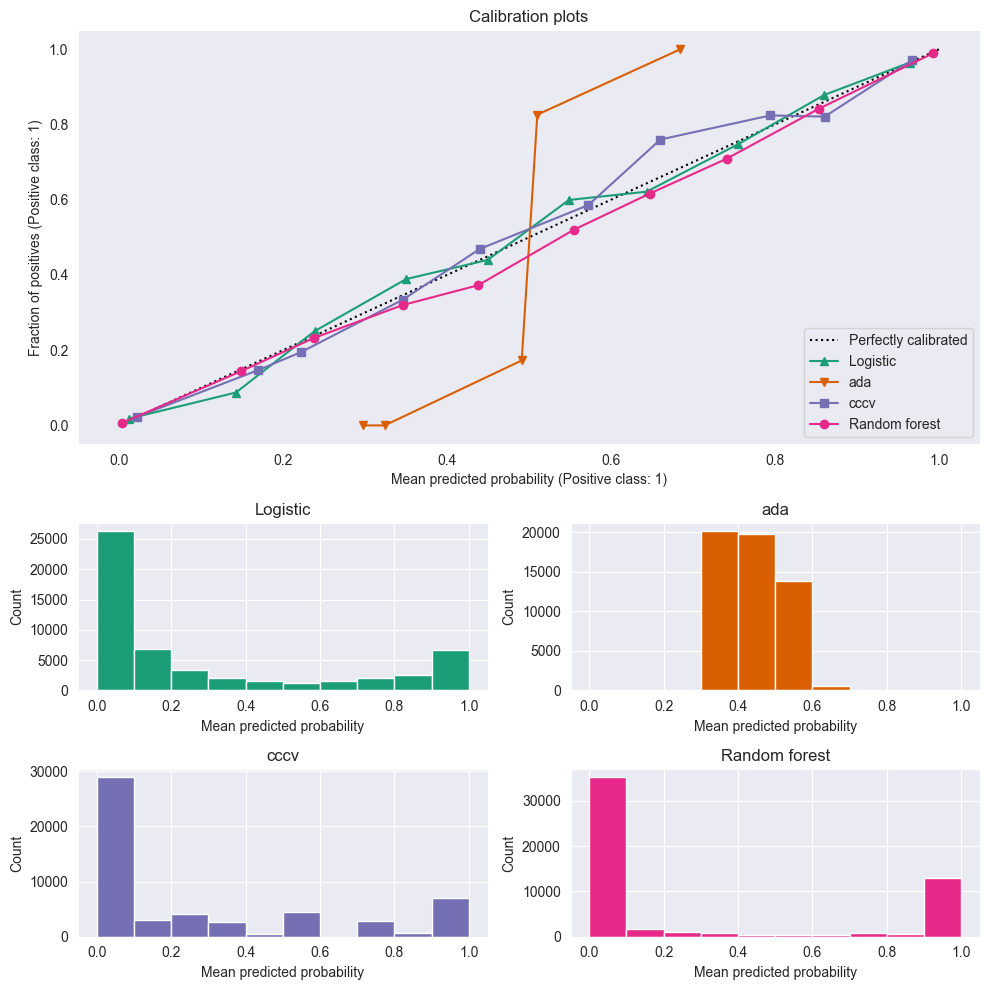

In [88]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list_2):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_train_2,
        y_test_train_2,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list_2):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [64]:
c = cccv.predict(X_test)
d = cccv.predict_proba(X_test)[:, 1]

In [65]:
calculate_metrics(y_test, c, d)

{'accuracy': 0.92,
 'log_loss': 0.184,
 'auc': 0.904,
 'aupcr': 0.932,
 'balanced_accuracy': 0.904,
 'f1': 0.849,
 'fbeta': 0.836,
 'precision': 0.828,
 'recall': 0.871,
 'mcc': 0.795,
 'jaccard': 0.737}

In [66]:
calculate_confusion_matrix_elements(y_test, c)

{'FP': 37546, 'TN': 558520, 'FN': 26582, 'TP': 180165}

In [68]:
cccv_2 = CalibratedClassifierCV(estimator=lgbm, method='isotonic', cv='prefit', n_jobs=-1)

X_test_train_2_new, y_test_train_2_new, X_test_new_2, y_test_new_2 = stratified_shuffle_split(
    X_test.iloc[:, :], y_test["tracker"]
)
cccv_2.fit(X_test_new_2, y_test_new_2)

CalibratedClassifierCV(cv='prefit', estimator=LGBMClassifier(random_state=10),
                       method='isotonic', n_jobs=-1)

In [70]:
e = cccv_2.predict(X_test_train_2_new)
f = cccv_2.predict_proba(X_test_train_2_new)[:, 1]

In [72]:
calculate_metrics(y_test_train_2_new, e, f)

{'accuracy': 0.928,
 'log_loss': 0.174,
 'auc': 0.895,
 'aupcr': 0.934,
 'balanced_accuracy': 0.895,
 'f1': 0.856,
 'fbeta': 0.874,
 'precision': 0.887,
 'recall': 0.827,
 'mcc': 0.809,
 'jaccard': 0.748}

In [73]:
calculate_confusion_matrix_elements(y_test_train_2_new, e)

{'FP': 17460, 'TN': 459393, 'FN': 28594, 'TP': 136803}

In [74]:
clf_list_3 = [
    (lr, "Logistic"),
    (lgbm, "lgbm"),
    (cccv, "cccv"),
    (cccv_2, "cccv_2"),
]

/var/folders/wk/770974_933q_mcw9wsl_nvkw0000gn/T/ipykernel_17805/3783463655.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pre

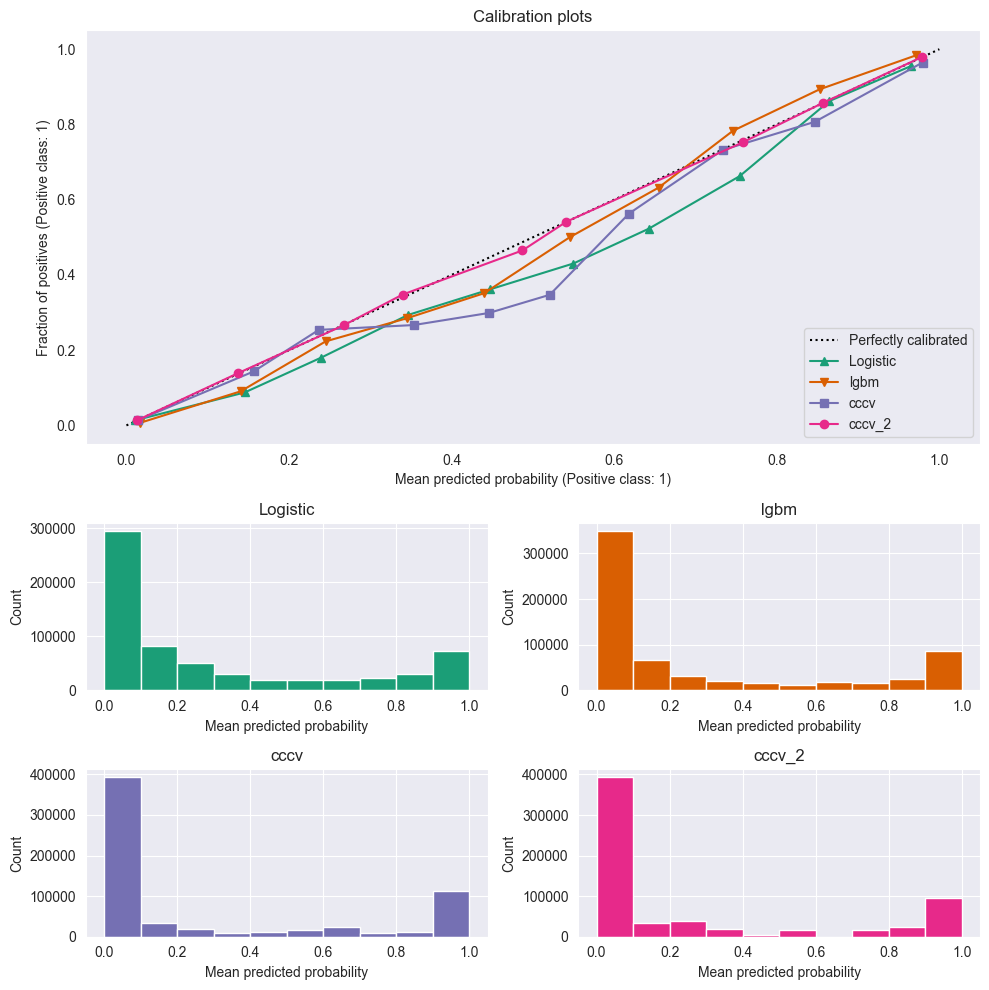

In [75]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list_3):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_train_2_new,
        y_test_train_2_new,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list_3):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [111]:
from matplotlib import colormaps


def plot_calibration_curves(clf_list, X_test, y_test):
    num_classifiers = len(clf_list)

    # Create a larger grid for the histograms
    fig = plt.figure(figsize=(10, num_classifiers * 5))
    gs = GridSpec(num_classifiers + 2, 2)
    colors = colormaps.get_cmap('Dark2')

    ax_calibration_curve = fig.add_subplot(gs[:2, :])
    calibration_displays = {}
    markers = ["^", "v", "s", "o", "D", "*", "P", "X", "d", "|", "_"]

    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i]
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")

    # Add histogram
    for i, (_, name) in enumerate(clf_list):
        ax = fig.add_subplot(gs[2 + i // 2, i % 2])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()

/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/github_projects/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax

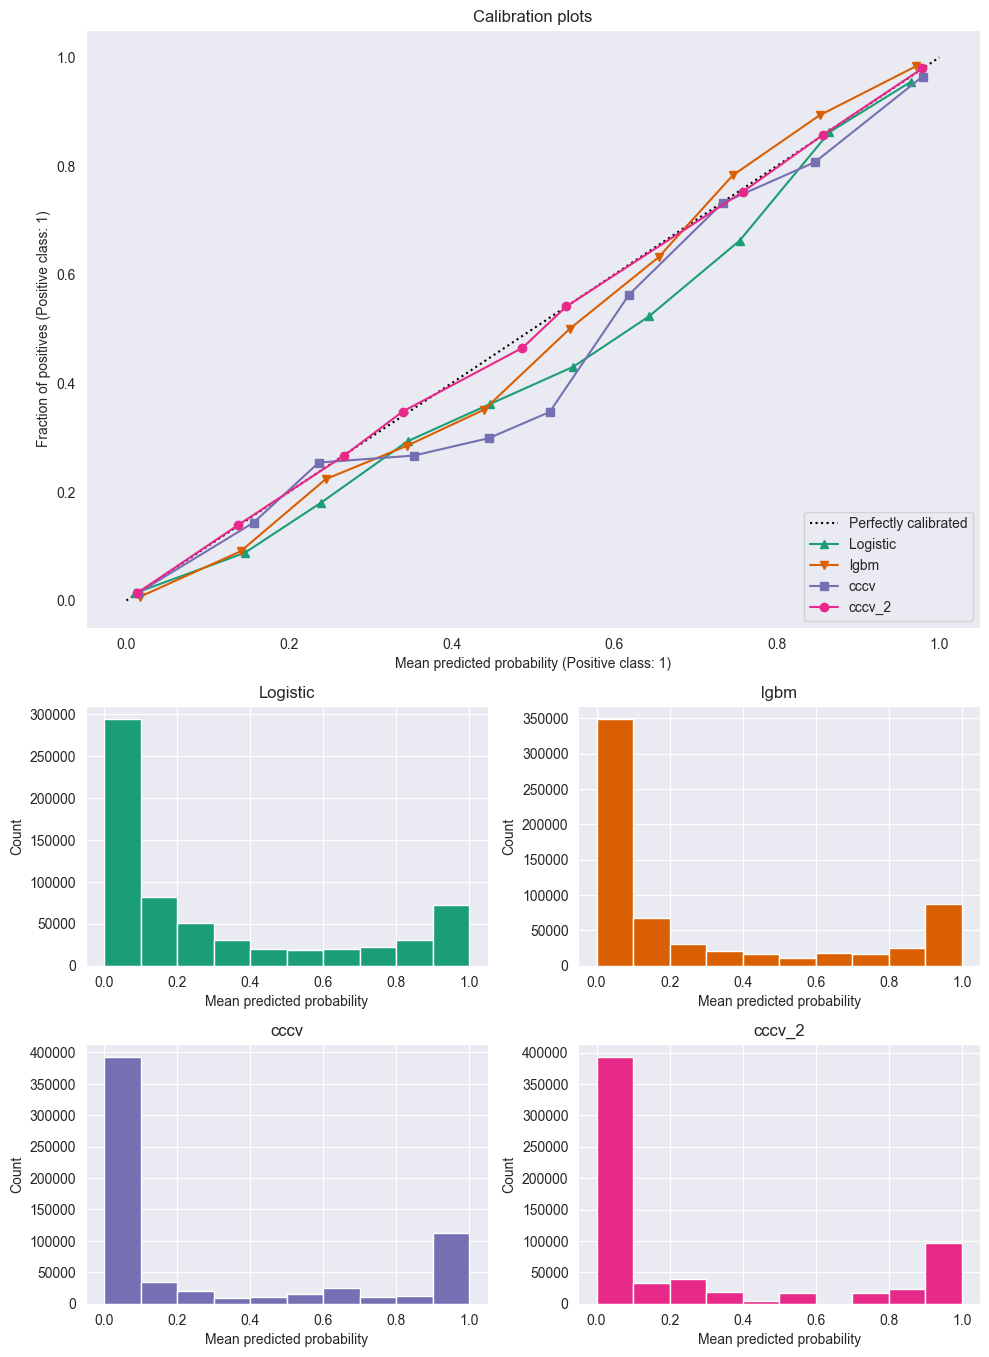

In [112]:
plot_calibration_curves(clf_list_3, X_test_train_2_new, y_test_train_2_new)